<a href="https://colab.research.google.com/github/TomRea1/SVM-MLP/blob/main/SVM%26MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [11]:
!pip install scikit-optimize

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [13]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier

# Provided code
The below code was not provided in its entirety nor was it necessarily applicable to all parts of this notebook. However, it is mostly not my work.

In [14]:
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

To compare the SVM with a NN:

In [15]:
def plot_decisions(X, y, model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_errors = 1- train_scores
    test_errors = 1-test_scores

    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")


    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [17]:
class MLPWrapper(BaseEstimator, ClassifierMixin):

    def __init__(self,  alpha=1e-5, solver='adam', layer1=10, layer2=10):
        self.layer1 = layer1
        self.layer2 = layer2
        self.solver = solver
        self.alpha = alpha

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2],
            max_iter = 2000,
            alpha = self.alpha
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [18]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=40,
)

In [19]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=40,
)

# Solutions

# **SVM**

In [20]:
data = np.loadtxt('/content/dataset_1_train.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]

print(X.shape)
print(y.shape)

(1001, 2)
(1001,)


In [21]:
def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# Hard-Margin SVM - C=1000

Hard-Margin-SVM, C=1000
Training Accuracy: 1.0




/tmp/ipython-input-31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


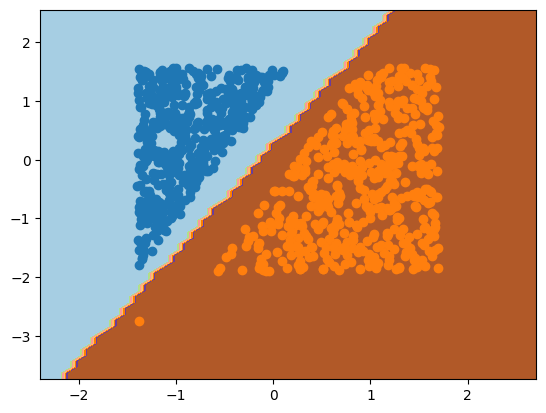

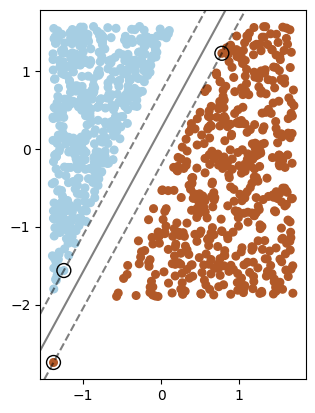

In [22]:
hard_margin_svm = svm.SVC(kernel='linear',C=1000)
hard_margin_svm.fit(X, y)
soft_margin_pred = hard_margin_svm.predict(X)
accuracy= accuracy_score(y, soft_margin_pred)


print('Hard-Margin-SVM, C=1000')
print(f"Training Accuracy: {accuracy}\n\n")

plot_decisions(X, y, hard_margin_svm)
plt.show()
plot_margin(X, y, hard_margin_svm)

# Soft-Margin SVM C=0.01

Soft-Margin-SVM, C=0.1
Training Accuracy: 0.999000999000999




/tmp/ipython-input-31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


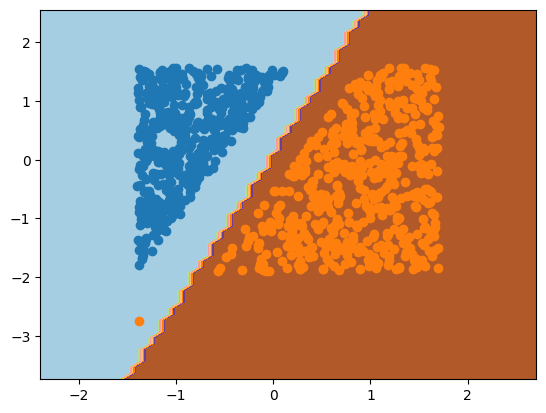

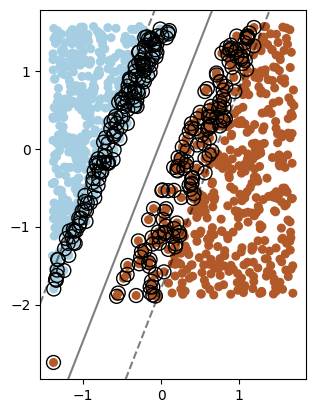

In [23]:
soft_margin_svm = svm.SVC(kernel='linear',C=0.01)
soft_margin_svm.fit(X, y)
soft_margin_pred = soft_margin_svm.predict(X)
accuracy= accuracy_score(y, soft_margin_pred)


print('Soft-Margin-SVM, C=0.1')
print(f"Training Accuracy: {accuracy}\n\n")

plot_decisions(X, y, soft_margin_svm)
plt.show()
plot_margin(X, y, soft_margin_svm)

# Exploring the Effects of Altering C Values (1e-5 to 1e5)

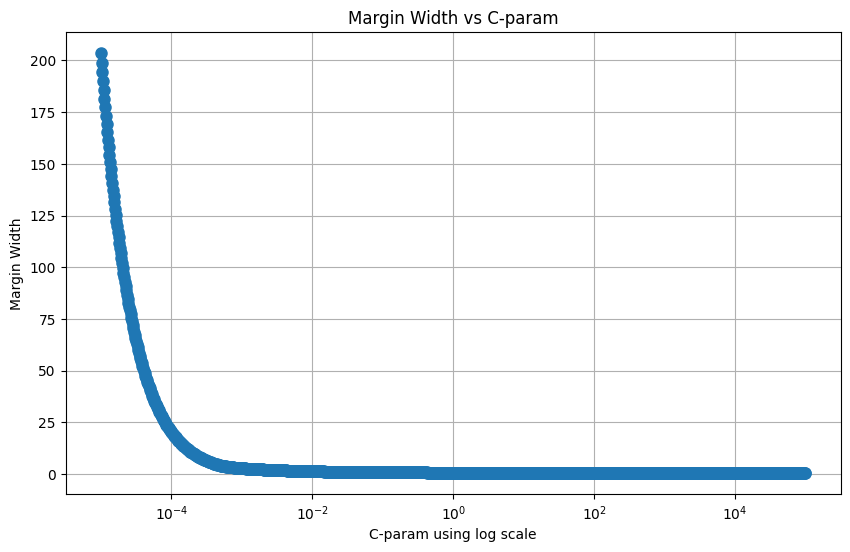

In [24]:
# c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
c_values = np.logspace(-5, 5, 1000)
margins = []
support_vectors = []

for c in c_values:
  model = svm.SVC(kernel='linear',C=c)
  model.fit(X, y)
  pred = model.predict(X)
  accuracy= accuracy_score(y, pred)

  margin = 2 / np.linalg.norm(model.coef_[0])
  margins.append(margin)
  support_vectors.append(len(model.support_vectors_))


# pltos
plt.figure(figsize=(10, 6))
plt.semilogx(c_values, margins, 'o-', linewidth=2, markersize=8)
plt.xlabel('C-param using log scale')
plt.ylabel('Margin Width')
plt.title('Margin Width vs C-param')
plt.grid(True)
plt.show()

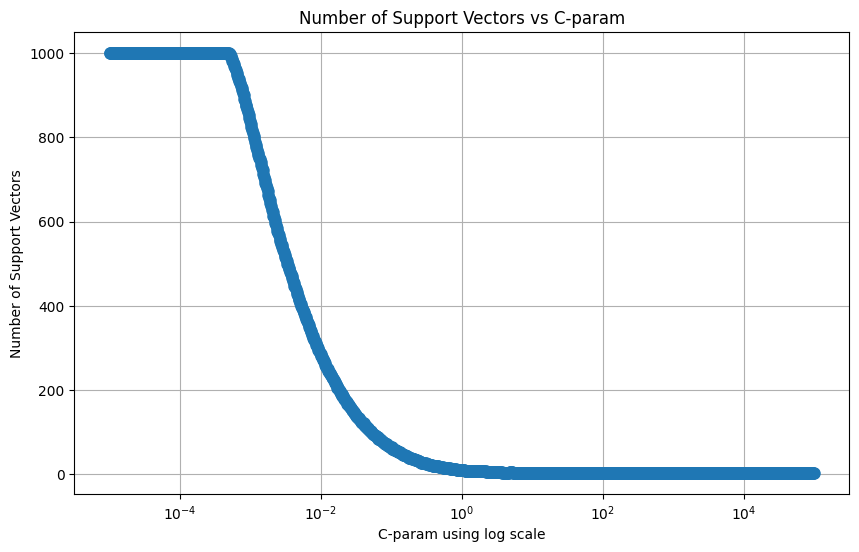

1001


In [25]:
# plots for sv's vs C params

plt.figure(figsize=(10, 6))
plt.semilogx(c_values, support_vectors, 'o-', linewidth=2, markersize=8)
plt.xlabel('C-param using log scale')
plt.ylabel('Number of Support Vectors')
plt.title('Number of Support Vectors vs C-param')
plt.grid(True)
plt.show()

print(len(y))

# Plotting SVMs with C Values (1e-5 to 1e3)

Some classmates asked me questions in the group forum that got me thinking about what happens to the SVM when the number of support vectors reaches its maximum (max support vectors = 1001) reached at around 10^-3 as we can see on the graph above. The plots below are a result of my investigation into this. I concluded that once the SVM starts considerign all support vectors it starts drawing the decision boundary beside the data on the lower right side instead of through the data in order to maximise margin size. As a result, margin width grows exponentially after C = 10^-3 and number of support vectors = 1001 (total data points), because the decision boundary is moving further and further from the data as a whole. Obviously, accuracy at this point stays at around 50% because no matter what decision boundary the linear SVM draws that doesn't bisect the data will correctly classify about half the points.

0.5004995004995005


/tmp/ipython-input-31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


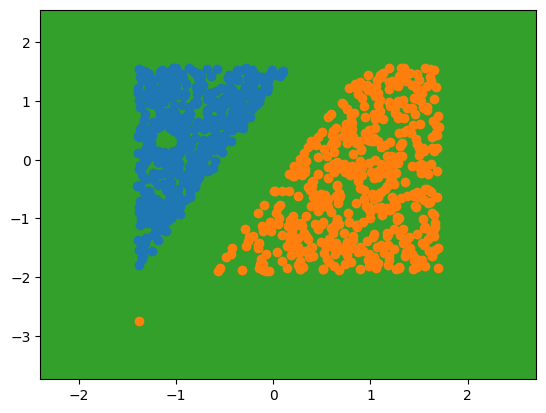

In [26]:
model = svm.SVC(kernel='linear',C=0.00001)
model.fit(X, y)
pred = model.predict(X)
print(accuracy_score(y, pred))
plot_decisions(X, y, model)



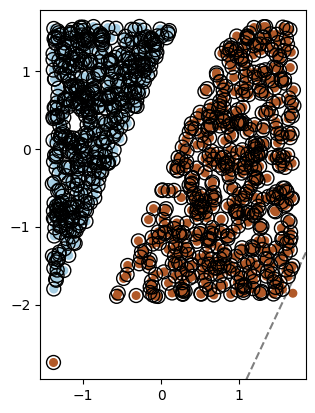

In [27]:
plot_margin(X, y, model)

0.5004995004995005


/tmp/ipython-input-31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


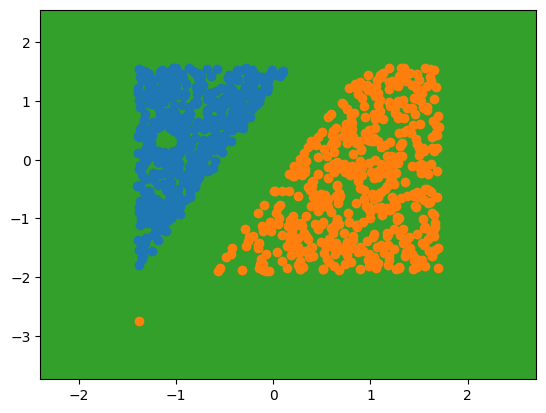

In [28]:
model = svm.SVC(kernel='linear',C=0.0001)
model.fit(X, y)
pred = model.predict(X)
print(accuracy_score(y, pred))
plot_decisions(X, y, model)


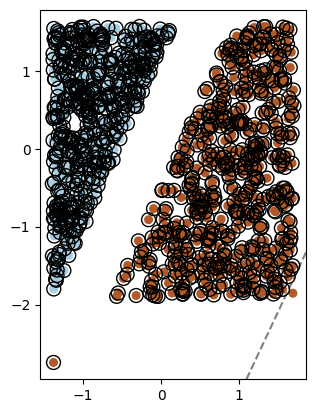

In [29]:
plot_margin(X, y, model)

0.998001998001998


/tmp/ipython-input-31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


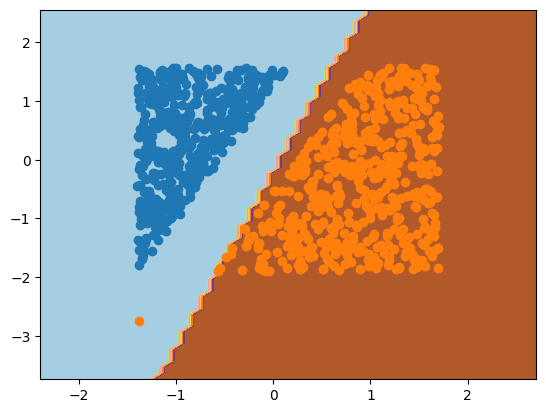

In [30]:
model = svm.SVC(kernel='linear',C=0.001)
model.fit(X, y)
pred = model.predict(X)
print(accuracy_score(y, pred))
plot_decisions(X, y, model)


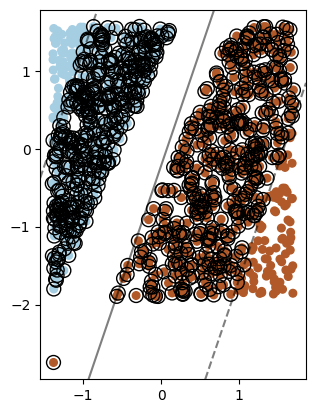

In [31]:
plot_margin(X, y, model)

**Whats happening to the margin as I vary the C-parameter.**

As you make the C-parameter higher, the margin width decreases. As this is happening, the model becomes stricter in a sense about correctly classifying every single training point (including outliers). The decision boundary can become more complex to accommodate every point. Lastly, the number of support vectors decreases as we can see on the graph above. As the C value increases, number support vectors and margin size approach a constant value and stay there.

The opposite happens as we decrease the C value. The margin increases, the model will allow a few missclassifications near the decision boundary, the decision boundary becomes smoother (less influenced by individual points) and the number of support vectors increases. (Please see above for what happens as the C value approaches 1e-4).  

-----

**How does the width of the margin affect the expected generalisationability of the model?**

The wider the margin, the better we can expect our model to generalsie to unseen data. A model with a wider margin should be more robust to noise and have less variance but could potentially have a high bias whcih would result in underfitting. If this was the case, our model wouldn't be sensitive enough and wouldn't generalise well. In our case here however, the margine eventually becomes extremely wide because its being drawn from the decision boundary outside the data to the data and is growing exponentially. So, in this case it would seem that the margin width is only a good measure for generalisability to a point. Although, to be fair since the decision boundary is so far away from our training data, it should very reliably correctly predict 50% of any test data that is binary and distributed evenly between the two classes.

Narrower margins generally lead to overfitting the training data, and higher variance and sensitivity to outliers and noise. Bias would be lower but generalisation is likely worse. In practice we would have to use cross validation to find our optimal C value as we did in e-tivity 2 with our lambda values.

# **Bayes Search for SVM and MLP**

In [32]:


# train
dataset_2_train = np.loadtxt('/content/dataset_2_train.csv', delimiter=',')
X_train_2 = dataset_2_train[:, :-1]
y_train_2 = dataset_2_train[:, -1]
dataset_3_train = np.loadtxt('/content/dataset_3_train.csv', delimiter=',')
X_train_3 = dataset_3_train[:, :-1]
y_train_3 = dataset_3_train[:, -1]
# test
dataset_2_test = np.loadtxt('/content/dataset_2_test.csv', delimiter=',')
X_test_2 = dataset_2_test[:, :-1]
y_test_2 = dataset_2_test[:, -1]
dataset_3_test = np.loadtxt('/content/dataset_3_test.csv', delimiter=',')
X_test_3 = dataset_3_test[:, :-1]
y_test_3 = dataset_3_test[:, -1]

print(X_train_2.shape)
print(y_train_2.shape)
print(X_train_3.shape)
print(y_train_3.shape)



(670, 2)
(670,)
(335, 2)
(335,)


# **Dataset 2**

# SVM Search

In [33]:
svm_search = BayesSearchCV(
    svm.SVC(),
    {
        'C': Real(1e-3, 1e3, prior='log-uniform'),
        'gamma' : Real(1e-4, 1, prior='log-uniform'),
        'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid']),

    },
    n_iter=30,
    cv=5,
    n_jobs=-1,
    random_state=42
)

svm_search.fit(X_train_2, y_train_2)
best_svm = svm_search.best_estimator_
accuracy = accuracy_score(y_train_2, best_svm.predict(X_train_2))
print(f"Best SVM: {best_svm}")
print(f"Best SVM Training Accuracy: {accuracy}")


Best SVM: SVC(C=1.8214548318355843, gamma=0.47867076737948444)
Best SVM Training Accuracy: 0.7761194029850746


In [34]:
print(f"Best SVM e_out = {1-best_svm.score(X_test_2, y_test_2)}")

Best SVM e_out = 0.25075528700906347


In [35]:
print(best_svm.degree)
print(best_svm.kernel)

3
rbf


# MLP Search

In [36]:
mlp_search = BayesSearchCV(
    MLPWrapper(),
    {
        'layer1' : Integer(1, 100),
        'layer2' : Integer(1, 100),
        'solver' : Categorical(['adam', 'sgd']),
        'alpha' : Real(1e-5, 1e-1, prior='log-uniform'),

    },
    n_iter=30,
    cv=5,
    n_jobs=-1,
    random_state=42
)


mlp_search.fit(X_train_2, y_train_2)
best_mlp = mlp_search.best_estimator_
accuracy = accuracy_score(y_train_2, best_mlp.predict(X_train_2))
print(f"Best MLP: {best_mlp}")

print(f"Best MLP Training Accuracy: {accuracy}")

Best MLP: MLPWrapper(alpha=0.022364202820542706, layer1=88, layer2=31, solver='sgd')
Best MLP Training Accuracy: 0.7805970149253731


In [37]:
print(best_mlp.solver)
best_mlp_e_out = 1-best_mlp.score(X_test_2, y_test_2)
print(f"Best MLP e_out = {best_mlp_e_out}")

sgd
Best MLP e_out = 0.22356495468277948


# Number of support vectors (SVM) , Number of parameters (MLP)

In [38]:
print(len(best_svm.support_vectors_))
print(sum(p.size for p in best_mlp.model.coefs_))

382
2935


# Decision Boundaries for Dataset 2

/tmp/ipython-input-31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


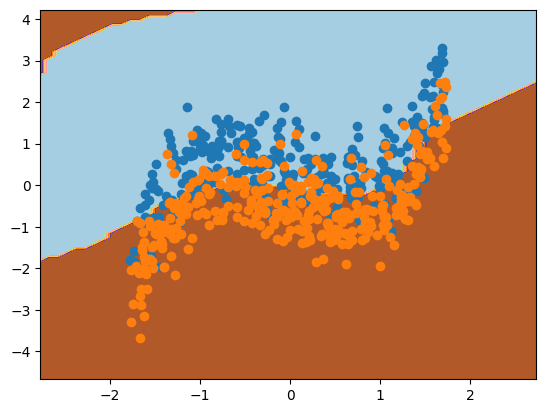

In [39]:
plot_decisions(X_train_2, y_train_2, best_svm)
plt.show()

/tmp/ipython-input-31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


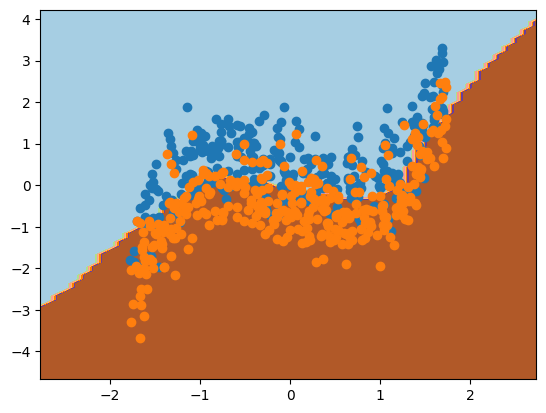

In [40]:
plot_decisions(X_train_2, y_train_2, best_mlp)
plt.show()

# **Dataset 3**

# SVM Search

In [41]:
svm_search.fit(X_train_3, y_train_3)
best_svm = svm_search.best_estimator_
accuracy = accuracy_score(y_train_3, best_svm.predict(X_train_3))
print(f"Best SVM: {best_svm}")
print(f"Best SVM Training Accuracy: {accuracy}")

Best SVM: SVC(C=1000.0, gamma=0.1067492862248133)
Best SVM Training Accuracy: 0.9731343283582089


In [42]:
print(f"Best SVM kernel = {best_svm.kernel}")
print(f"Best SVM e_out = {1-best_svm.score(X_test_3, y_test_3)}")

Best SVM kernel = rbf
Best SVM e_out = 0.030303030303030276


# MLP Search

In [43]:
mlp_search.fit(X_train_3, y_train_3)
best_mlp = mlp_search.best_estimator_
accuracy = accuracy_score(y_train_3, best_mlp.predict(X_train_3))
print(f"Best MLP: {best_mlp}")
print(f"Best MLP Training Accuracy: {accuracy}")

print(f"Best MLP e_out = {1-best_mlp.score(X_test_3, y_test_3)}")

Best MLP: MLPWrapper(layer1=49, layer2=100)
Best MLP Training Accuracy: 0.982089552238806
Best MLP e_out = 0.024242424242424288


# Plot Decision Boundaries

adam


/tmp/ipython-input-31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


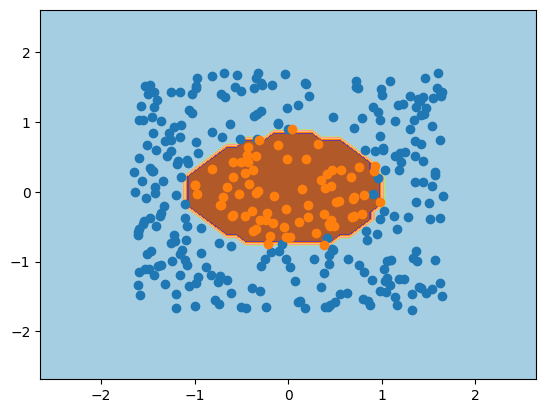

In [44]:
print(best_mlp.solver)
plot_decisions(X_train_3, y_train_3, best_svm)
plt.show()

/tmp/ipython-input-31159057.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


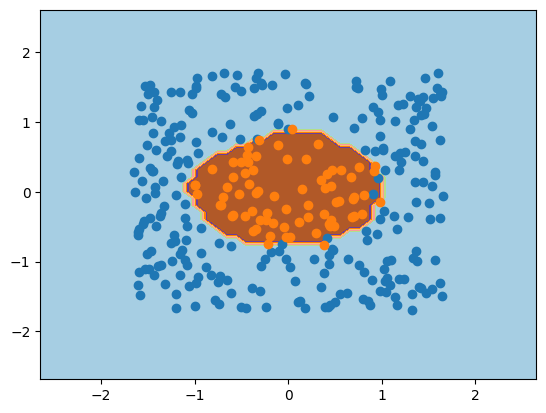

In [45]:
plot_decisions(X_train_3, y_train_3, best_mlp)
plt.show()

# Support Vectors (SVM) , Parameters (MLP)

*This isn't an error its to do with the order I ran the cells in. I don't want to run the searches again.

In [46]:
print(len(best_svm.support_vectors_))
print(sum(W.size for W in best_mlp.model.coefs_) + sum(b.size for b in best_mlp.model.intercepts_))

24
5248


# Grid Search V.S Bayes Search

In [48]:

# Grid Search

timed_grid_search = GridSearchCV(
    estimator=model,
    param_grid={

        'C': np.logspace(-3, 3, 10),
        'gamma' : np.logspace(-4, 0, 10),
        'degree': [2, 3, 4, 5],
        'coef0': np.linspace(0.0, 1.0, 5),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']

    },
    n_jobs=-1

)


# Bayes Search


timed_bayes_search = BayesSearchCV(
    model,
    {
        'C': Real(1e-3, 1e3, prior='log-uniform'),
        'gamma' : Real(1e-4, 1, prior='log-uniform'),
        'degree': Integer(2, 5),
        'coef0': Real(0.0, 1.0),
        'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid'])
    },
    n_jobs=-1,
    random_state=42,
    n_iter=100,
    n_points=5
)

In [54]:
# start = time.perf_counter()
# timed_grid_search.fit(cp.asarray(X_train_2).get(), cp.asarray(y_train_2).get())
# end = time.perf_counter()
# print(f"Grid Search Time: {(end - start):.6f}")

In [55]:
# start = time.perf_counter()
# timed_bayes_search.fit(cp.asarray(X_train_2).get(), cp.asarray(y_train_2).get())
# end = time.perf_counter()
# print(f"Bayes Search Time: {(end-start):.6f}")

How does the number of hyper-parameters to be tuned affect the length/computational complexity of the Bayesian tuning process? And how does this compare to a grid search?

As we increase the number of hyperparameters in BayesSearchCV(), the search space grows requiring more and more time and compute to find an answer. This holds true for any search strategy Bayes or Grid Search. Bayes outperformed Grid Search in every instance in this notebook as it is essentially an exhaustive search of every combination of hyperparameters whereas BayesSearch defines a probabalistic model and intelligently identifies which points to evaluate next. Grid search divides the hyperparameter space into a fixed grid which means you have to search (possible values for hyperparams) to the power of (no.hyperparameters). **You can see from the output above, the number of iterations each search method resulted in. This result aligns with my understanding of exhaustive search v.s bayes approach. (10,000 vs 25,000) **

----

For dataset 2, which model was the most complex and why?

In dataset 2, I belive the MLP is more complex. The measure I have chosen to evaluate this is support vectors v.s weights. This is not a perfect measure but it does help when trying to evaluate the models. Even though in this dataset, bayes search chose the rbf kernel that maps to an infinite dimensional space in which the svm draws a hyperplane to approximate the target function and separate the data, this infinite dimensional space is considerably bounded by the moderate C value = 1.82 meaning the model is moderately constrained to perfect fit but not to the extent of say C=1000. Gamma is also moderate to high making the kernel more localised but not extremely localised.

----

For dataset 3, which model was the most complex and why?


The optimal MLP for dataset 2 settled on 93 and 37 neurons in layers 1 and 2. Regularisation here was also relatively light with alpha=0.0078 allowing for the flexible decision boundary but also quite a large search space. To sum up, the MLP is more complex here as the rbf-svm is quite practically constrained by C and gamma and while the MLP is also constrained by alpha, we're still dealing with 3664 trainable parameters vs 384 support vectors where the svm is more regularised than the MLP.

**3)** In dataset 3, the optimal SVM has the maximum C value allowed in the search (1000). The rbf kernel is used again so we're dealing with a theoretically infinite dimensional space but since its only using 24 support vectors we can determine that the data is easily separable for the SVM. The MLP has half the parameters than it did for the last dataset, but still a significant number - 1207. If you want to define complexity as trainable parameters, obviouslt the MLP is more complex again here but this isn't a perfect measure because this data is so easily separable when we introduce non-linearity and just because this SVM only needed 24 support vectors to classify this decision boundary doesn't necessarily mean its more complex than the MLP in this case.

# **Reflection**





After completing this project my understanding of hyperparameters has grown. I have learned the impacts of the adjusting the regularisation parameter in linear SVMs. I have learned how adjusting the hyperparameter ranges and hyperparameters themselves can impact complexity and compute requirements in Grid Search and Bayes Search -- they make them more complex. I have also learned how important tuning these hyperparameters is. Theres no one set of hyperparameters that will guarentee performance on any dataset - theres no free lunch. Each dataset requires its own set of hyperparameters. Take MLP for example. If we have a small dataset, adam will be preferable as it is above. For large we might need to employ SGD. For datasets 2 and 3, the rbf kernel is preferable but thay would be too complex for dataset 1 where a linear kernel is required. Those are quite big things but seemingly small parameters such as the gamma regularisation term for the rbf kernel can require substantially different values for different data e.g 0.47867076737948444 for dataset 2 and 0.10674925771199258 for dataset 3. And look at the difference in results below if we try and use the dataset 3 gamma value on dataset 2 :



In [52]:
example_svm = svm.SVC(kernel='rbf',gamma=0.10674925771199258)
dataset_2_train = np.loadtxt('/content/dataset_2_train.csv', delimiter=',')
X_train_2 = dataset_2_train[:, :-1]
y_train_2 = dataset_2_train[:, -1]

dataset_2_test = np.loadtxt('/content/dataset_2_test.csv', delimiter=',')
X_test_2 = dataset_2_test[:, :-1]
y_test_2 = dataset_2_test[:, -1]

example_svm.fit(X_train_2, y_train_2)
pred = example_svm.predict(X_train_2)
print("\n.................. Dataset 2 ..................\n\n")
print(f"-------- Results with sub-optimal Gamma --------\n")
print(f"Training accuracy {accuracy_score(y_train_2, pred)}")
print(f"e_out : {1-example_svm.score(X_test_2, y_test_2)}\n")
print(f"-------- Results with optimal Gamma --------\n")
print("Training accuracy : 0.7761194029850746")
print("e_out : 0.25075528700906347")


.................. Dataset 2 ..................


-------- Results with sub-optimal Gamma --------

Training accuracy 0.7298507462686568
e_out : 0.27794561933534745

-------- Results with optimal Gamma --------

Training accuracy : 0.7761194029850746
e_out : 0.25075528700906347
